# Pancreatic endocrinogenesis

In [1]:
import ocelli as oci
import scvelo as scv
import scanpy as scp
import matplotlib as mpl
from collections import Counter

mpl.rcParams['figure.dpi'] = 200

SEED = 17

## Load the data

In [73]:
adata = scv.datasets.pancreas()
adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [74]:
Counter(adata.obs['clusters'])

Counter({'Pre-endocrine': 592,
         'Ductal': 916,
         'Alpha': 481,
         'Ngn3 high EP': 642,
         'Delta': 70,
         'Beta': 591,
         'Ngn3 low EP': 262,
         'Epsilon': 142})

## Preprocess the data

In [75]:
scp.pp.filter_genes(adata, min_cells=50)
oci.pp.LDA(adata, n_components=20, output_key='lda', verbose=1, max_iter=50, random_state=SEED)
oci.pp.modality_generation(adata, topic_key='lda', norm_log=True, verbose=False)

iteration: 1 of max_iter: 50
iteration: 2 of max_iter: 50
iteration: 3 of max_iter: 50
iteration: 4 of max_iter: 50
iteration: 5 of max_iter: 50
iteration: 6 of max_iter: 50
iteration: 7 of max_iter: 50
iteration: 8 of max_iter: 50
iteration: 9 of max_iter: 50
iteration: 10 of max_iter: 50
iteration: 11 of max_iter: 50
iteration: 12 of max_iter: 50
iteration: 13 of max_iter: 50
iteration: 14 of max_iter: 50
iteration: 15 of max_iter: 50
iteration: 16 of max_iter: 50
iteration: 17 of max_iter: 50
iteration: 18 of max_iter: 50
iteration: 19 of max_iter: 50
iteration: 20 of max_iter: 50
iteration: 21 of max_iter: 50
iteration: 22 of max_iter: 50
iteration: 23 of max_iter: 50
iteration: 24 of max_iter: 50
iteration: 25 of max_iter: 50
iteration: 26 of max_iter: 50
iteration: 27 of max_iter: 50
iteration: 28 of max_iter: 50
iteration: 29 of max_iter: 50
iteration: 30 of max_iter: 50
iteration: 31 of max_iter: 50
iteration: 32 of max_iter: 50
iteration: 33 of max_iter: 50
iteration: 34 of ma

In [76]:
adata.uns = {'modalities': adata.uns['modalities']}
adata.write('p.h5ad')

In [2]:
import anndata
adata = anndata.read_h5ad('p.h5ad')

In [78]:
scv.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
scv.pp.log1p(adata)

scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:02) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:03) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/4 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:21) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [7]:
import numpy as np
from statsmodels.distributions.empirical_distribution import ECDF
import ray
from multiprocessing import cpu_count
import anndata
import pandas as pd
from scipy.sparse import issparse


@ray.remote
def weights_worker(modalities, nn, ecdfs, split):
    w = list()
    for cell in split:
        cell_scores = list()
        for m0, _ in enumerate(modalities):
            modality_scores = list()
            nn_ids = nn[m0][cell]
            for m1, M1 in enumerate(modalities):
                if m0 != m1:
                    if issparse(M1):
                        axis_distances = np.linalg.norm(M1[nn_ids].toarray() - M1[cell].toarray(), axis=1)
                    else:
                        axis_distances = np.linalg.norm(M1[nn_ids] - M1[cell], axis=1)
                    modality_scores.append(ecdfs[m1](axis_distances))
                else:
                    modality_scores.append(np.zeros(nn_ids.shape))
            cell_scores.append(modality_scores)
        w.append(cell_scores)

    w = np.sum(np.median(np.asarray(w), axis=3), axis=1)

    return w


@ray.remote
def scaling_worker(w, nn, split, alpha=10):
    weights_scaled = np.asarray([np.mean(w[nn[np.argmax(w[obs])][obs], :], axis=0) for obs in split])

    for i, row in enumerate(weights_scaled):
        if np.max(row) != 0:
            weights_scaled[i] = row / np.max(row)
        row_exp = np.exp(weights_scaled[i]) ** alpha
        weights_scaled[i] = row_exp / np.sum(row_exp)

    return weights_scaled


def weights(adata: anndata.AnnData,
            n_pairs: int = 1000,
            modalities=None,
            neighbors_key: str = 'neighbors',
            weights_key: str = 'weights',
            n_jobs: int = -1,
            random_state=None,
            verbose: bool = False,
            copy: bool = False):
    n_jobs = cpu_count() if n_jobs == -1 else min([n_jobs, cpu_count()])

    if not ray.is_initialized():
        ray.init(num_cpus=n_jobs)

    if neighbors_key not in adata.uns:
        raise(KeyError('No nearest neighbors found. Run ocelli.pp.neighbors.'))

    modality_names = adata.uns['modalities'] if modalities is None else modalities

    if random_state is not None:
        np.random.seed(random_state)

    n_modalities = len(modality_names)
    modalities = [adata.obsm[m].toarray() if issparse(adata.obsm[m]) else adata.obsm[m] for m in modality_names]

    nn = adata.uns[neighbors_key]
    n_obs = adata.shape[0]

    if n_modalities > 1:
        pairs = np.random.choice(range(n_obs), size=(n_pairs, 2))
        ecdfs = list()
        for m in modalities:
            if issparse(m):
                modality_dists = [np.linalg.norm(m[pairs[i, 0]].toarray() - m[pairs[i, 1]].toarray(), axis=None)
                                  for i in range(n_pairs)]
            else:
                modality_dists = [np.linalg.norm(m[pairs[i, 0]] - m[pairs[i, 1]], axis=None) for i in range(n_pairs)]
            ecdfs.append(ECDF(modality_dists))

        splits = np.array_split(range(n_obs), n_jobs)
        modalities_ref = ray.put(modalities)
        nn_ref = ray.put(nn)
        ecdfs_ref = ray.put(ecdfs)
        weights = ray.get([weights_worker.remote(modalities_ref, nn_ref, ecdfs_ref, split) for split in splits])
        weights = np.vstack(weights)

        weights_ref = ray.put(weights)
        weights = ray.get([scaling_worker.remote(weights_ref, nn_ref, split) for split in splits])
        weights = np.concatenate(weights, axis=0)
    else:
        weights = np.ones((n_obs, 1))

    adata.obsm[weights_key] = pd.DataFrame(weights, index=list(adata.obs.index), columns=modality_names)

    if verbose:
        print('Multimodal cell-specific weights estimated.')

    if ray.is_initialized():
        ray.shutdown()

    return adata if copy else None


In [8]:
import time
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
now = time.time()
oci.tl.weights(adata, random_state=SEED, verbose=False)
print(time.time() - now)
w1 = adata.obsm['weights']

now = time.time()
weights(adata, random_state=SEED, verbose=False)
print(time.time() - now)
w2 = adata.obsm['weights']

20 nearest neighbors calculated.
19.78539538383484
20.17531991004944


In [11]:
(w1 == w2)

,modality0,modality1,modality2,modality3,modality4,modality5,modality6,modality7,modality8,modality9,modality10,modality11,modality12,modality13,modality14,modality15,modality16,modality17,modality18,modality19
index,,,,,,,,,,,,,,,,,,,,
AAACCTGAGAGGGATA,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
AAACCTGAGCCTTGAT,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
AAACCTGAGGCAATTA,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
AAACCTGCATCATCCC,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
AAACCTGGTAAGTGGC,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTCAAGTGACATA,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
TTTGTCAAGTGTGGCA,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
TTTGTCAGTTGTTTGG,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


## Multimodal Diffusion Maps

In [79]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.weights(adata, random_state=SEED, verbose=True)
oci.tl.MDM(adata, n_components=20, random_state=SEED, verbose=True)

20 nearest neighbors calculated.
Multimodal cell-specific weights estimated.
Unimodal Markov chain calculated (1/20)
Unimodal Markov chain calculated (2/20)
Unimodal Markov chain calculated (3/20)
Unimodal Markov chain calculated (4/20)
Unimodal Markov chain calculated (5/20)
Unimodal Markov chain calculated (6/20)
Unimodal Markov chain calculated (7/20)
Unimodal Markov chain calculated (8/20)
Unimodal Markov chain calculated (9/20)
Unimodal Markov chain calculated (10/20)
Unimodal Markov chain calculated (11/20)
Unimodal Markov chain calculated (12/20)
Unimodal Markov chain calculated (13/20)
Unimodal Markov chain calculated (14/20)
Unimodal Markov chain calculated (15/20)
Unimodal Markov chain calculated (16/20)
Unimodal Markov chain calculated (17/20)
Unimodal Markov chain calculated (18/20)
Unimodal Markov chain calculated (19/20)
Unimodal Markov chain calculated (20/20)
Multimodal Markov chain calculated
Eigendecomposition finished.
20 Multimodal Diffusion Maps components calculat

## Plotting

In [80]:
oci.pp.neighbors(adata, modalities=['X_mdm'], neighbors_key='neighbors_mdm', n_neighbors=100, verbose=True)
oci.tl.vel_graph(adata, n=15, neighbors_key='neighbors_mdm', verbose=True)

oci.tl.FA2(adata, n_components=2, n_steps=4000, random_state=SEED, output_key='X_fa2')

100 nearest neighbors calculated.
RNA velocity-based graph constructed.


Oct 03, 2022 12:59:38 AM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Oct 03, 2022 12:59:39 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 3,696 (3,696 added)
Oct 03, 2022 12:59:39 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 55,440 (53,880 added)


*************************25%
*************************50%
*************************75%
******

*******************100%
Time = 35.983s


(<Figure size 1200x800 with 1 Axes>, <AxesSubplot:>)

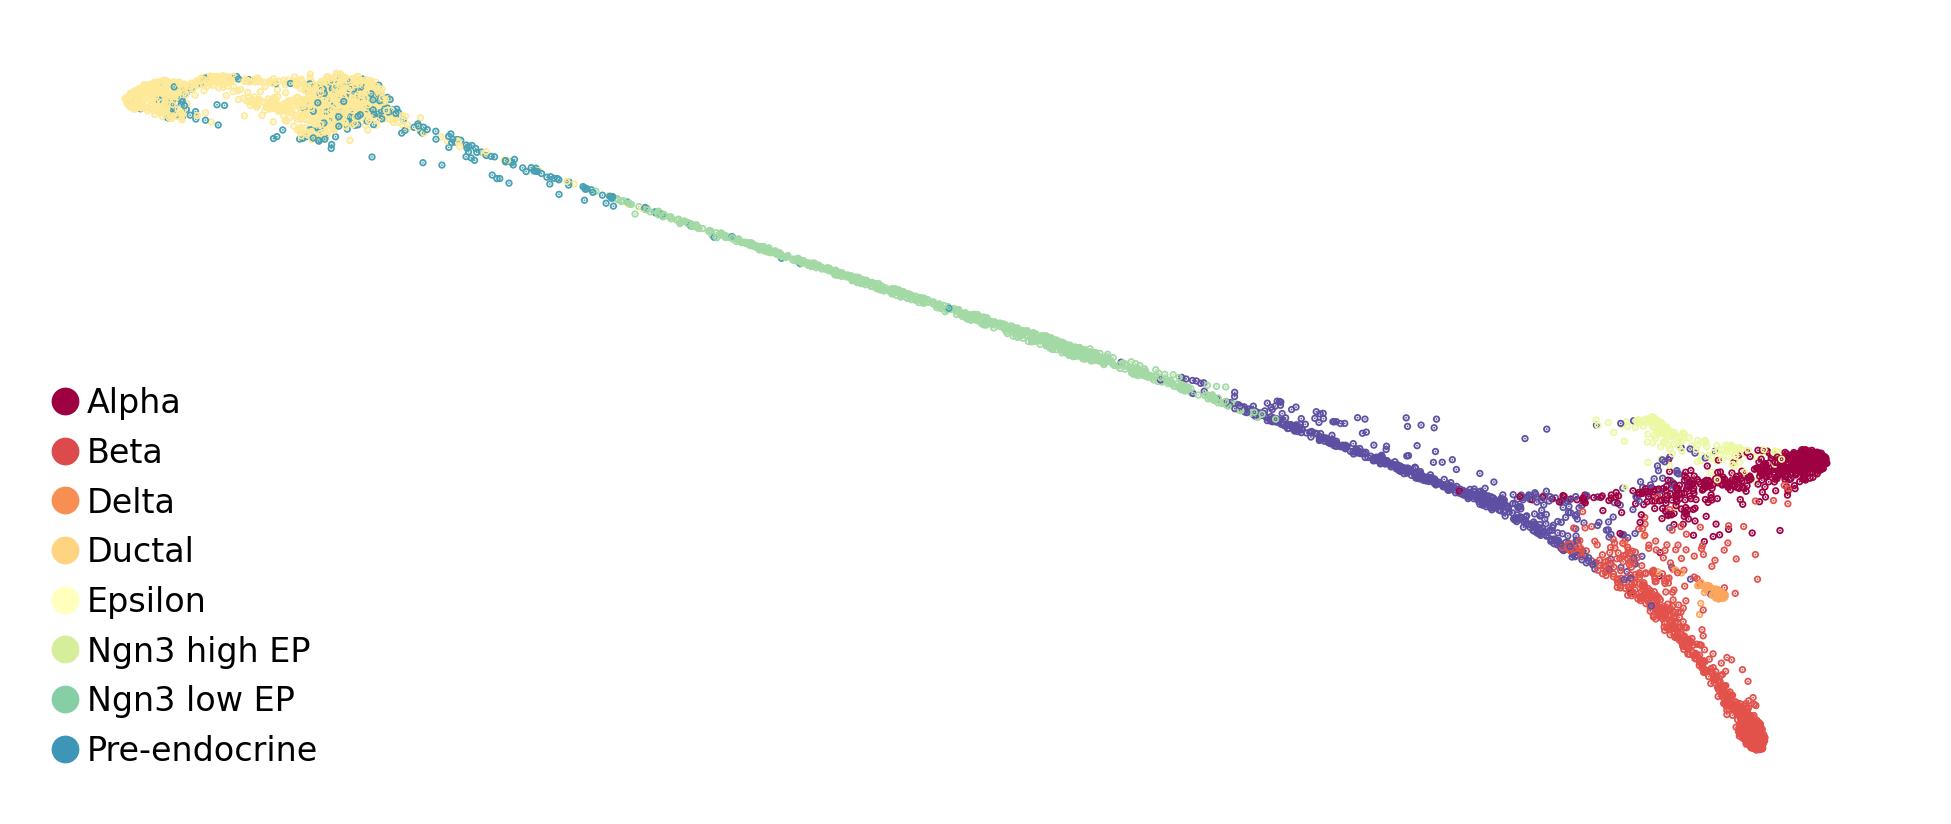

In [81]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='clusters', static=True, marker_size=0.1)

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_fa2', embedded velocity vectors (adata.obsm)


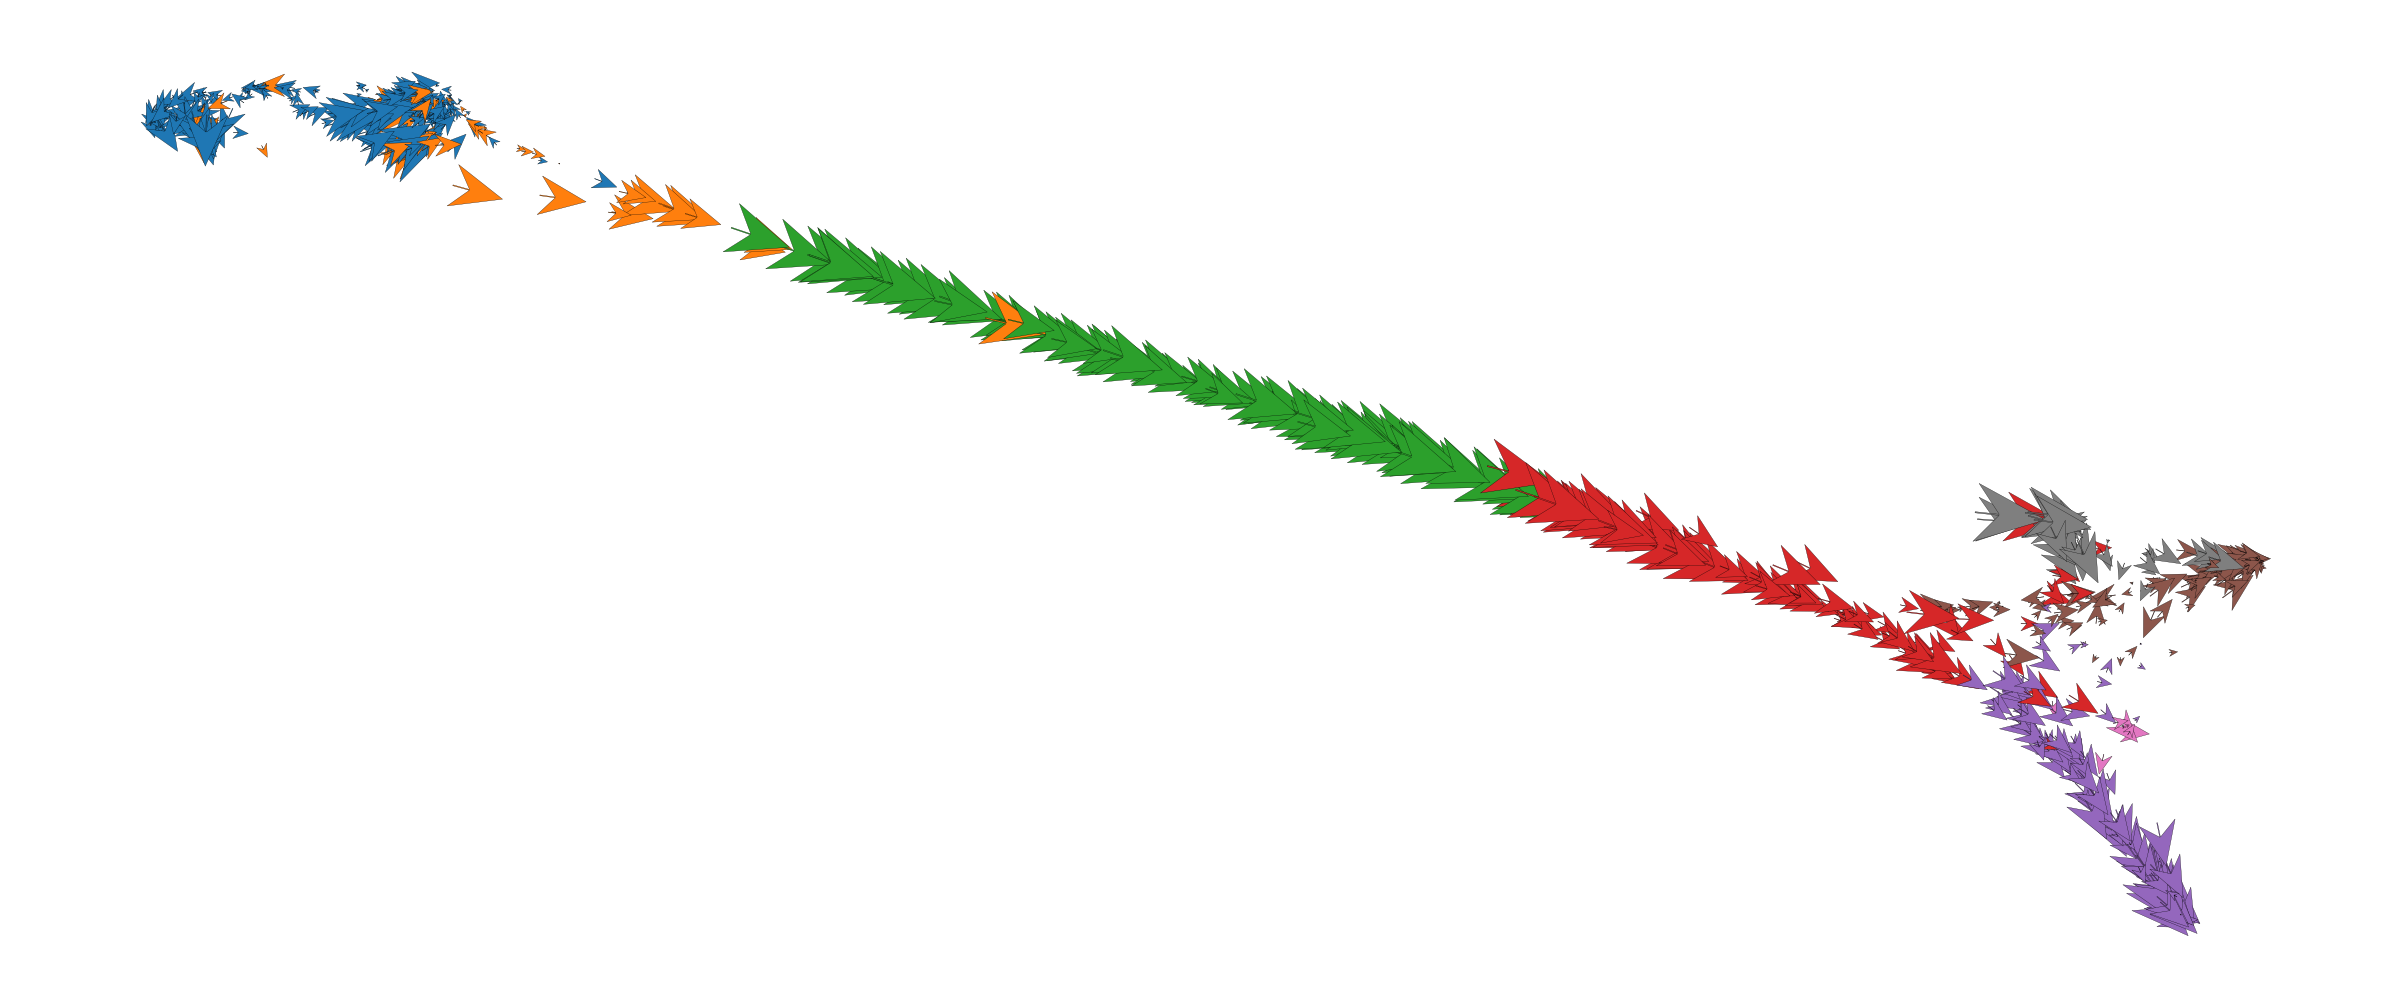

In [82]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

scv.set_figure_params(transparent=False, format='png', frameon=False, dpi=200, facecolor='white', fontsize=6)
scv.pl.velocity_embedding(adata, basis='fa2', arrow_length=7, arrow_size=5, alpha=0, color_map='jet', 
                          title='', dpi=200, density=0.2, 
                          linewidth=0.05, show=False, ax=ax)
ax.set_aspect('equal')
plt.tight_layout()

(<Figure size 1200x800 with 2 Axes>, <AxesSubplot:>)

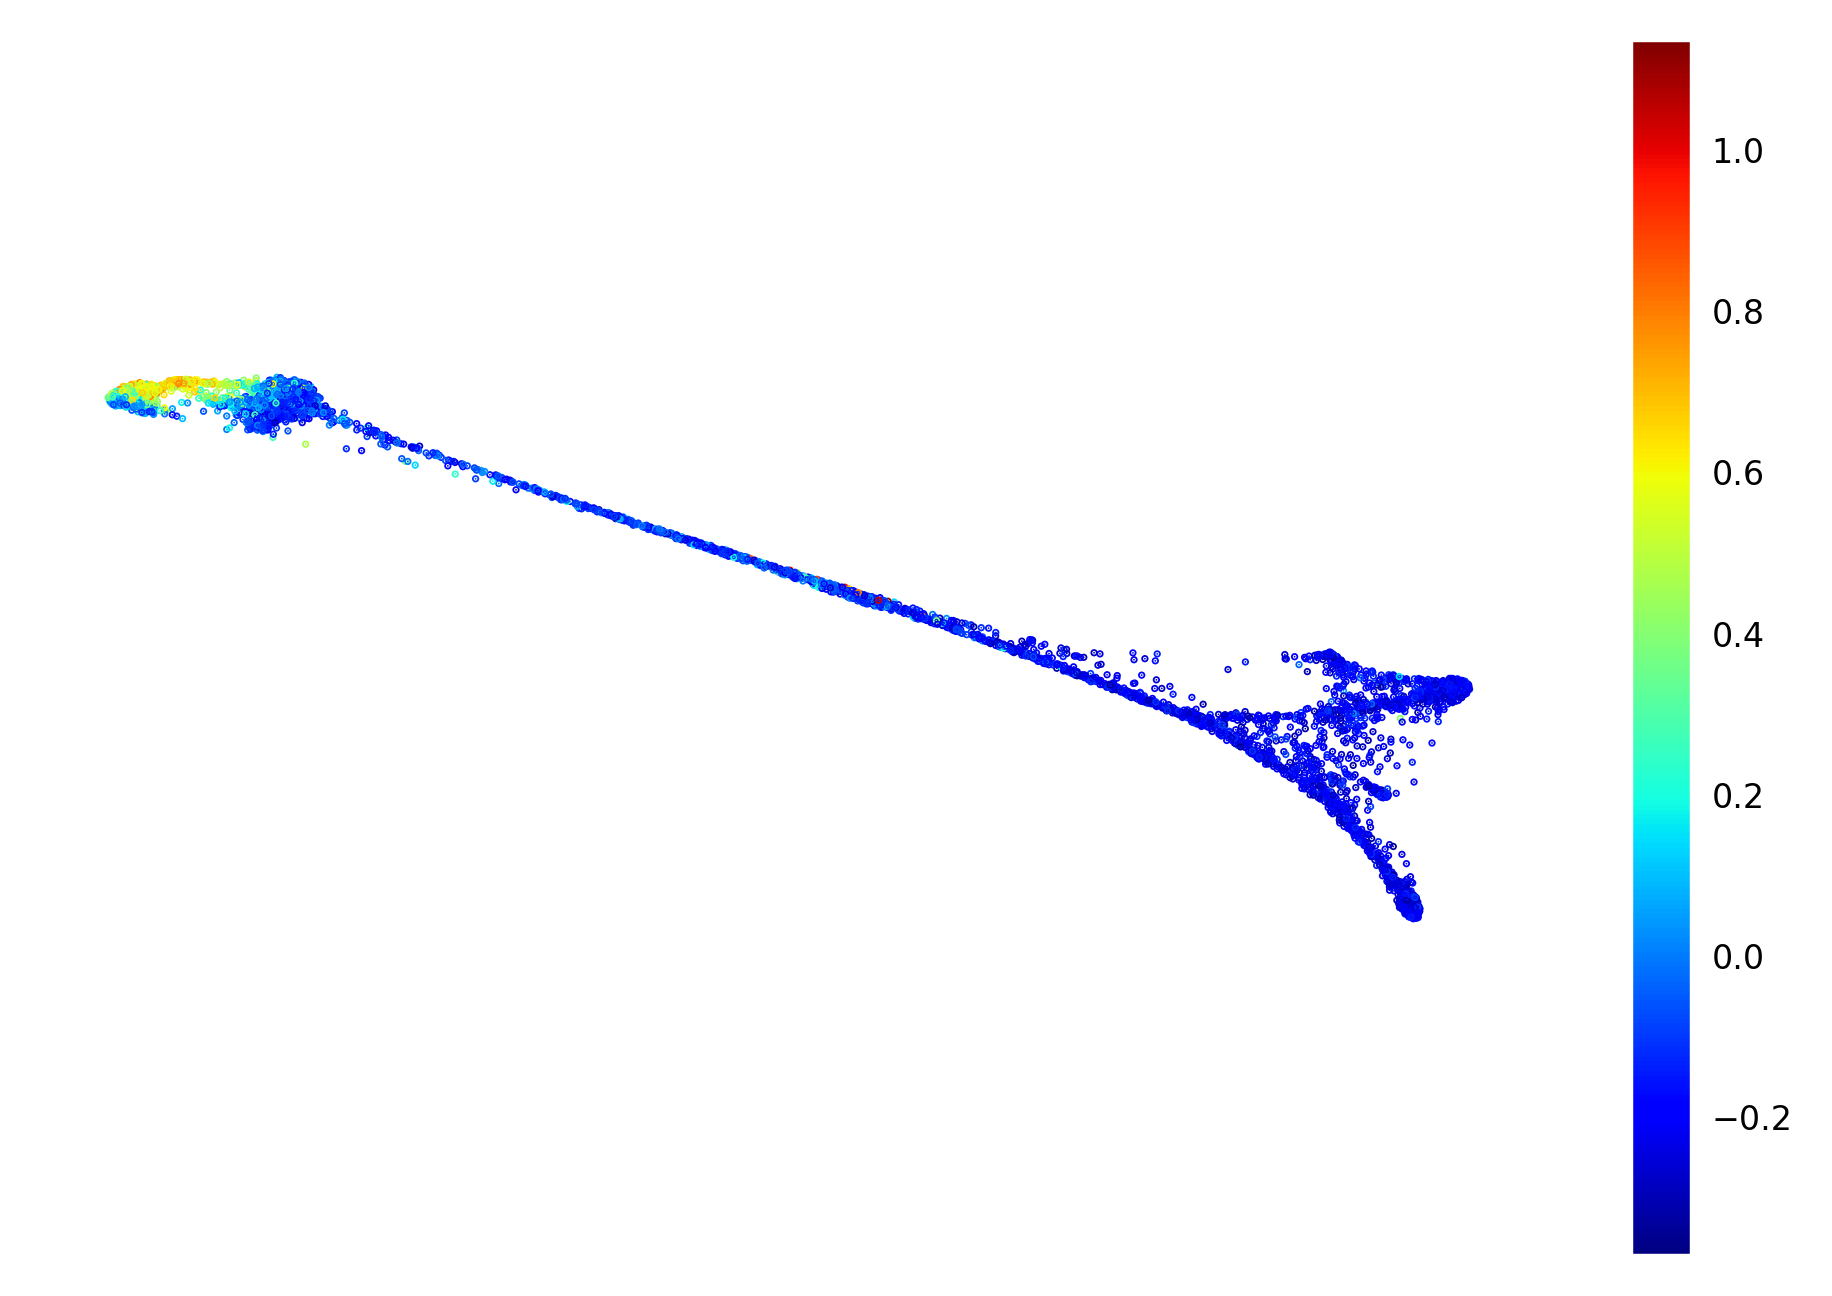

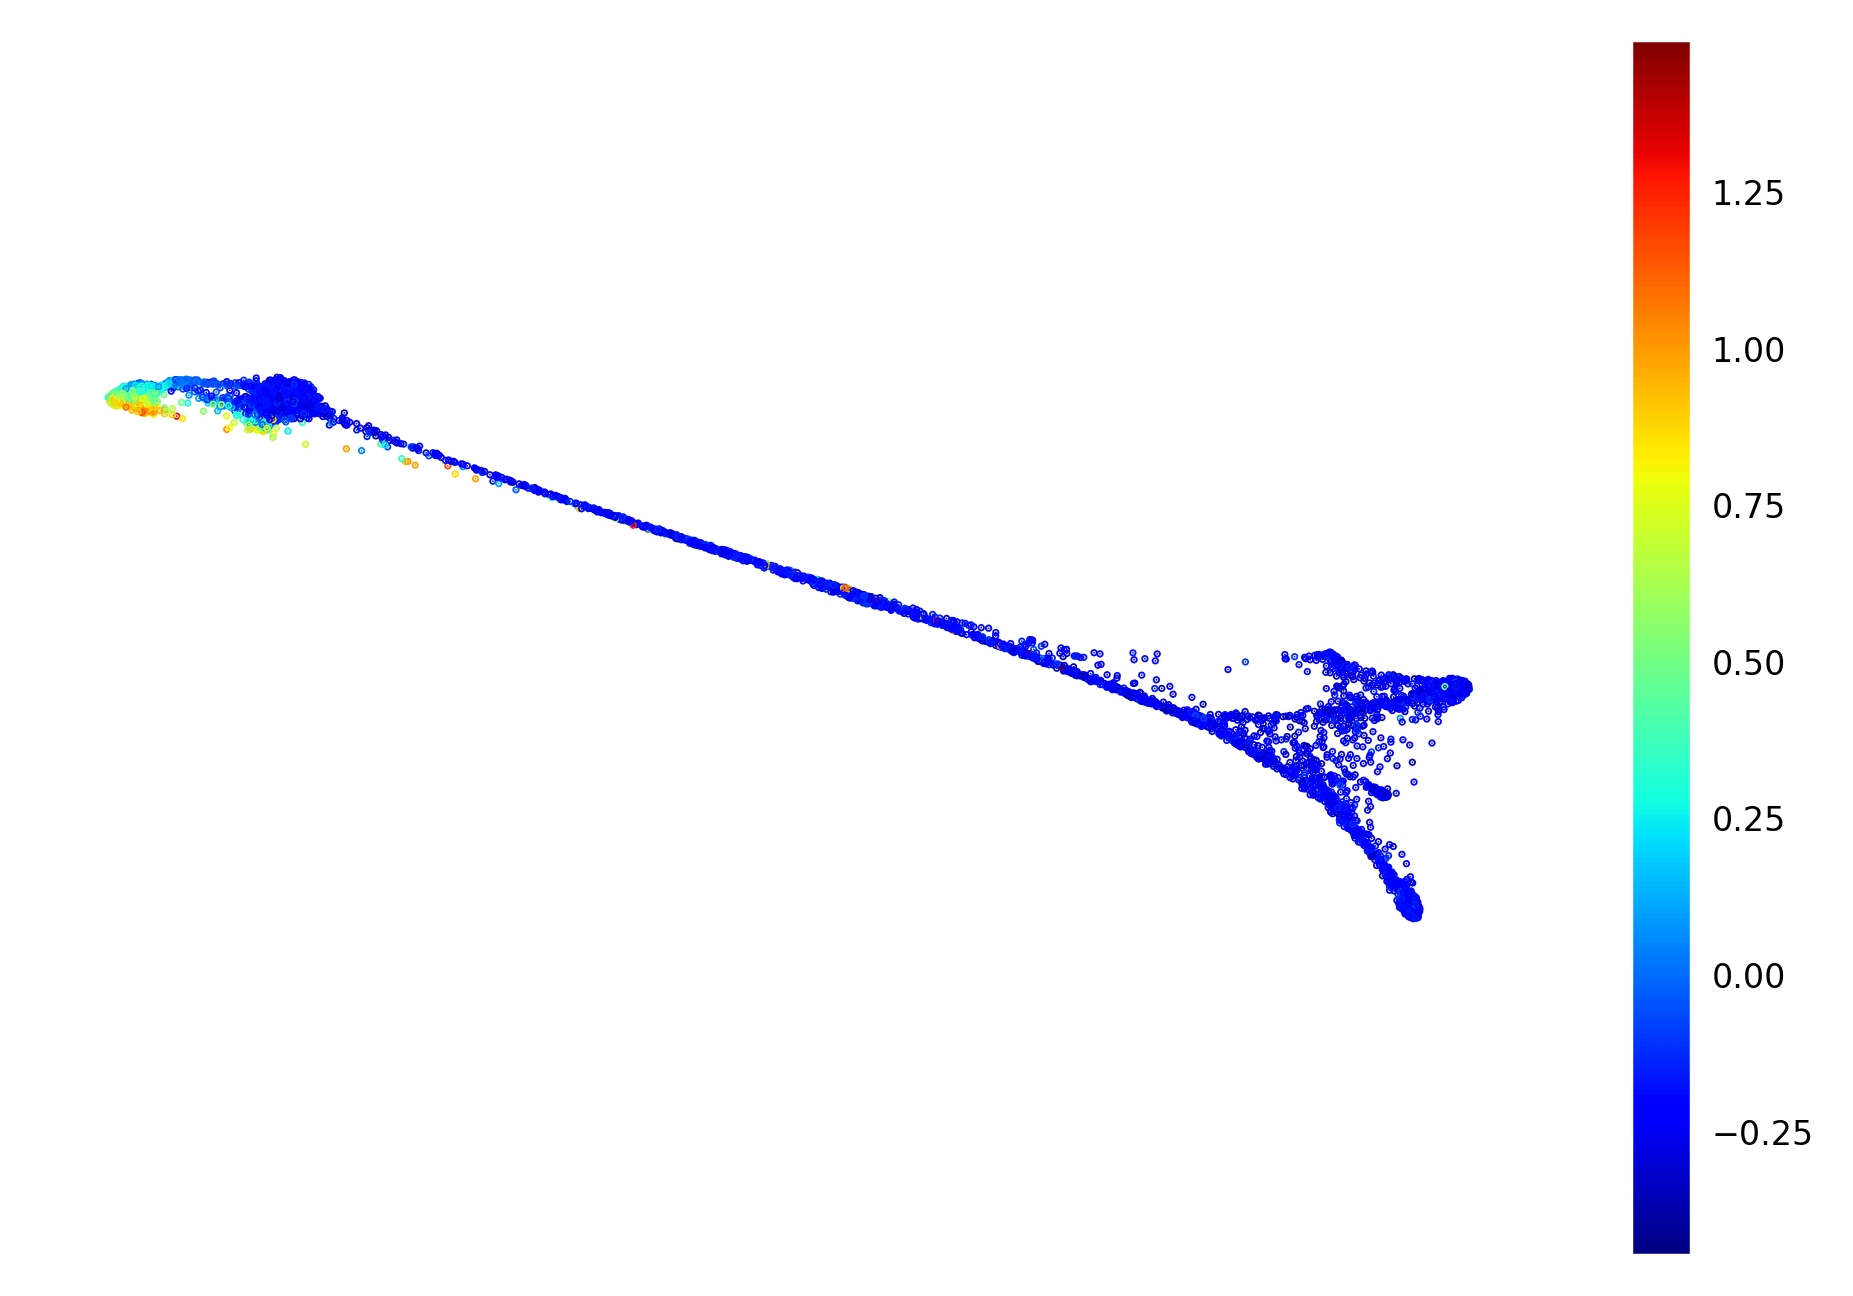

In [83]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='S_score', cmap='jet', marker_size=0.1)
oci.pl.scatter(adata, x_key='X_fa2', color_key='G2M_score', cmap='jet', marker_size=0.1)

(<Figure size 1500x1200 with 20 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>],
        [<AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>],
        [<AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>,
         <AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>],
        [<AxesSubplot:title={'center':'15'}>,
         <AxesSubplot:title={'center':'16'}>,
         <AxesSubplot:title={'center':'17'}>,
         <AxesSubplot:title={'center':'18'}>,
         <AxesSubplot:title={'center':'19'}>]], dtype=object))

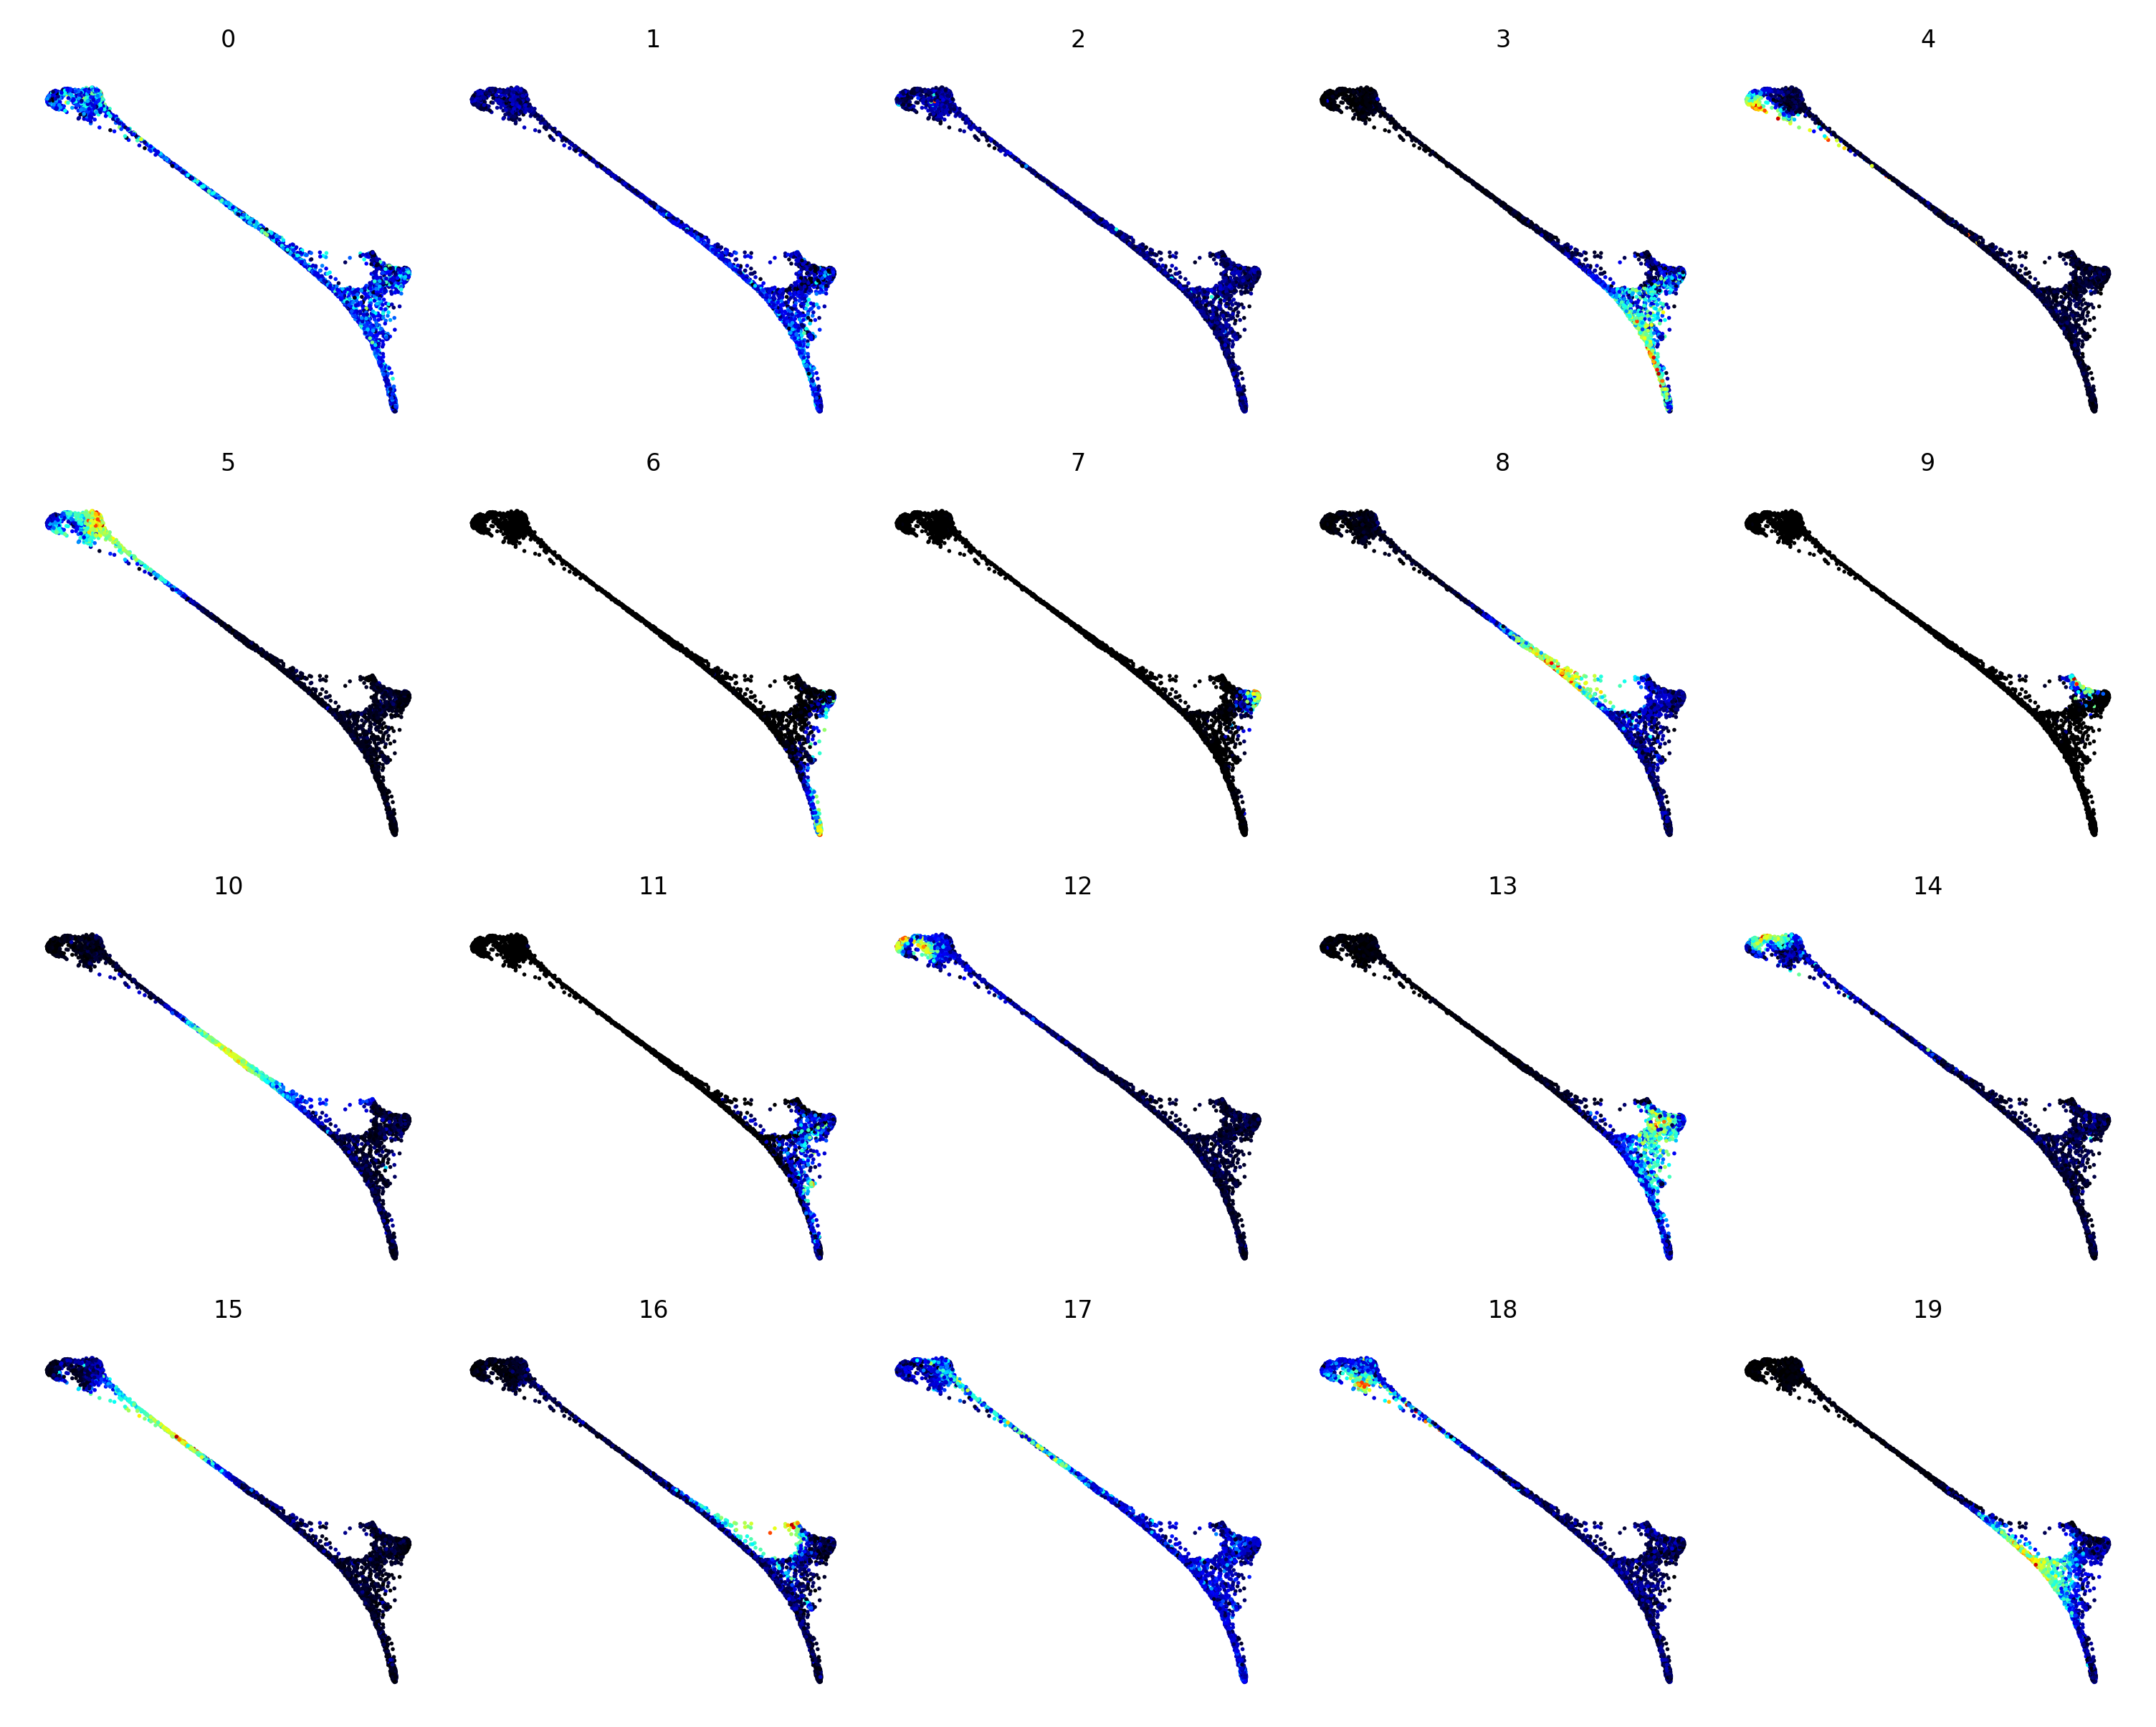

In [84]:
oci.pl.topics(adata, x_key='X_fa2')